TITLE ; MOVIE REVIEW

OBJECTIVE ; To develop an NLP-based system that analyzes and classifies movie reviews by extracting sentiments and opinions expressed in text, enabling accurate prediction of whether reviews are positive or negative to assist users in making informed viewing choices."

DATASET ; The Large Movie Review Dataset from Stanford (https://ai.stanford.edu/~amaas/data/sentiment/) similarly has 25,000 labeled training and 25,000 labeled testing reviews for binary sentiment analysis.

In [1]:
import pandas as pd
import numpy as np
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

In [4]:
# LOAD THE DATASET FROM DRIVE
from google.colab import files

# This will prompt you to upload the file from your local machine
uploaded = files.upload()


Saving movie review.gz to movie review.gz


In [8]:
# RENAME THE DATASET
import os
os.rename("movie review.gz", "aclImdb_v1.tar.gz")


In [9]:
# EXTRACT DATASET
!tar -xvzf aclImdb_v1.tar.gz

Streaming output truncated to the last 5000 lines.
aclImdb/train/unsup/44983_0.txt
aclImdb/train/unsup/44982_0.txt
aclImdb/train/unsup/44981_0.txt
aclImdb/train/unsup/44980_0.txt
aclImdb/train/unsup/44979_0.txt
aclImdb/train/unsup/44978_0.txt
aclImdb/train/unsup/44977_0.txt
aclImdb/train/unsup/44976_0.txt
aclImdb/train/unsup/44975_0.txt
aclImdb/train/unsup/44974_0.txt
aclImdb/train/unsup/44973_0.txt
aclImdb/train/unsup/44972_0.txt
aclImdb/train/unsup/44971_0.txt
aclImdb/train/unsup/44970_0.txt
aclImdb/train/unsup/44969_0.txt
aclImdb/train/unsup/44968_0.txt
aclImdb/train/unsup/44967_0.txt
aclImdb/train/unsup/44966_0.txt
aclImdb/train/unsup/44965_0.txt
aclImdb/train/unsup/44964_0.txt
aclImdb/train/unsup/44963_0.txt
aclImdb/train/unsup/44962_0.txt
aclImdb/train/unsup/44961_0.txt
aclImdb/train/unsup/44960_0.txt
aclImdb/train/unsup/44959_0.txt
aclImdb/train/unsup/44958_0.txt
aclImdb/train/unsup/44957_0.txt
aclImdb/train/unsup/44956_0.txt
aclImdb/train/unsup/44955_0.txt
aclImdb/train/unsup/4

The purpose of the below code is to manually load the IMDB movie review dataset from a local directory structure into a pandas DataFrame for analysis:

It defines a function load_imdb_data that traverses through the dataset folders (train and test), and within each, the sentiment subfolders (pos and neg).

For each text review file in those folders, it reads the content and appends it to the data dictionary under "review".

It labels each review as 1 if positive (pos) and 0 if negative (neg), appending this sentiment label to the data dictionary.

Finally, it returns the whole dataset as a pandas DataFrame with columns "review" (text content) and "sentiment" (binary label).

The code then loads the dataset from /content/aclImdb directory into df and prints its shape and sample rows.

This approach is used when the IMDB dataset is stored locally (already downloaded and extracted) in the standard folder layout, enabling easy programmatic loading of raw review texts and their sentiment labels for natural language processing tasks.

In [12]:
import os
import pandas as pd

def load_imdb_data(data_dir):
    data = {"review": [], "sentiment": []}
    for set_type in ["train", "test"]:
        for sentiment in ["pos", "neg"]:
            folder = os.path.join(data_dir, set_type, sentiment)
            for file in os.listdir(folder):
                with open(os.path.join(folder, file), encoding="utf-8") as f:
                    data["review"].append(f.read())
                    data["sentiment"].append(1 if sentiment=="pos" else 0)
    return pd.DataFrame(data)

# load everything
data_dir = "/content/aclImdb"
df = load_imdb_data(data_dir)

print(df.shape)
df.head()


(50000, 2)


,review,sentiment
0,"It's hard to say which comes out on top, James...",1
1,This film is stunningly beautiful. Goldsworthy...,1
2,Homicide: The Movie proved to be a good wrap-u...,1
3,Watching this again after a gap of many years ...,1
4,This film had my heart pounding. The acting wa...,1


The purpose of the code steps below is for cleaning raw text in NLP is to make the text uniform and suitable for modeling by:

Lowercase conversion: Ensures consistency by treating words with different cases as the same (e.g., “Apple” and “apple” become “apple”), reducing vocabulary size and noise.

Removing HTML tags and special characters: Cleans out irrelevant markup and unwanted symbols that do not add meaning but could confuse models.

Removing extra spaces: Normalizes spacing so that words are properly separated, preventing errors in tokenization.

Overall, these cleaning steps reduce noise and irregularities in raw text data, improving the quality of text representation and enabling machine learning models to better learn meaningful patterns for tasks such as sentiment analysis, classification, or translation.

In [13]:
# CLEAN TEXT raw text data to make it uniform and suitable for vectorization and modeling.
# Lowercase conversion of text
# Removing HTML tags and special characters
# Remove extra spaces

import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = set(stopwords.words("english"))

def clean_text(text):
    text = text.lower()
    text = re.sub(r"<.*?>", " ", text)   # remove HTML tags
    text = re.sub(r"[^a-zA-Z]", " ", text)  # keep only letters
    text = " ".join([word for word in text.split() if word not in stop_words])
    return text

df["clean_review"] = df["review"].apply(clean_text)
df.head()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,review,sentiment,clean_review
0,"It's hard to say which comes out on top, James...",1,hard say comes top james cagney charm energy m...
1,This film is stunningly beautiful. Goldsworthy...,1,film stunningly beautiful goldsworthy art real...
2,Homicide: The Movie proved to be a good wrap-u...,1,homicide movie proved good wrap well written w...
3,Watching this again after a gap of many years ...,1,watching gap many years remembering flop upon ...
4,This film had my heart pounding. The acting wa...,1,film heart pounding acting great erotic music ...


The objective of converting text to numerical vectors using TF-IDF and sequence padding is:

Transform text into numeric vectors: TF-IDF captures the importance of words in each document relative to the entire corpus, enabling machine learning models to process textual data quantitatively.

Prepare data for LSTM input: Tokenizing text into sequences of integers translates words into indices, and padding sequences to a fixed length (e.g., max_len=200) ensures uniform input size, which is required for the sequential model architecture like LSTM.

In [14]:
# Convert Text to Numerical Vectors (TF-IDF)
# Converts text into sequences of integers called vectors using tokenizer.
# Pads sequences to make all reviews the same length (max_len=200) for LSTM input.

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Parameters
max_words = 20000   # keep top 20k words in vocab
max_len = 200       # pad/truncate all reviews to length 200

# Initialize tokenizer
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(df["clean_review"])

# Convert reviews to integer sequences
sequences = tokenizer.texts_to_sequences(df["clean_review"])

# Pad sequences to fixed length
X = pad_sequences(sequences, maxlen=max_len, padding="post", truncating="post")

y = df["sentiment"].values

print("Shape of X:", X.shape)
print("Shape of y:", y.shape)


Shape of X: (50000, 200)
Shape of y: (50000,)


Training set: Used to train the machine learning model, allowing it to learn patterns from the data.

Test set: Used to evaluate the model’s performance on new, unseen data to assess its generalization ability.

This separation helps simulate real-world scenarios where the model encounters data it hasn't seen before, preventing overfitting and providing a reliable estimate of how well the model will perform in practice. In essence, train-test split enables unbiased model evaluation and ensures that the model is not simply memorizing the training data but can generalize to make accurate predictions on new data.

In [15]:
# TRAIN, TEST, SPLIT
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(X_train.shape, X_test.shape)

(40000, 200) (10000, 200)


In [17]:
# BUILD AN LSTM MODEL
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

embedding_dim = 100

model = Sequential([
    Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len),
    LSTM(128, return_sequences=False),
    Dropout(0.5),
    Dense(1, activation="sigmoid")
])

# Force build with expected input shape (batch, sequence length)
model.build(input_shape=(None, max_len))

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 200, 100)       │     2,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       117,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,117,377 (8.08 MB)

 Trainable params: 2,117,377 (8.08 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
# TRAIN MODEL
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stop = EarlyStopping(
    monitor="val_loss", patience=2, restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    "best_lstm.h5", monitor="val_loss", save_best_only=True
)

history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[early_stop, checkpoint],
    verbose=1
)

Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step - accuracy: 0.5066 - loss: 0.6936

313/313 ━━━━━━━━━━━━━━━━━━━━ 150s 472ms/step - accuracy: 0.5066 - loss: 0.6936 - val_accuracy: 0.5024 - val_loss: 0.6920
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step - accuracy: 0.5264 - loss: 0.6888

313/313 ━━━━━━━━━━━━━━━━━━━━ 157s 502ms/step - accuracy: 0.5264 - loss: 0.6888 - val_accuracy: 0.5041 - val_loss: 0.6918
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step - accuracy: 0.5069 - loss: 0.6933

313/313 ━━━━━━━━━━━━━━━━━━━━ 148s 473ms/step - accuracy: 0.5069 - loss: 0.6933 - val_accuracy: 0.5187 - val_loss: 0.6862
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step - accuracy: 0.5613 - loss: 0.6566

313/313 ━━━━━━━━━━━━━━━━━━━━ 158s 504ms/step - accuracy: 0.5616 - loss: 0.6564 - val_accuracy: 0.8165 - val_loss: 0.4274
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step - accuracy: 0.8648 - loss: 0.3472

313/313 ━━━━━━━━━━━━━━━━━━━━ 149s 475ms/step - accuracy: 0.8648 - loss: 0.3471 - val_accuracy: 0.8863 - val_loss: 0.2796
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step - accuracy: 0.9313 - loss: 0.1956

313/313 ━━━━━━━━━━━━━━━━━━━━ 148s 474ms/step - accuracy: 0.9313 - loss: 0.1956 - val_accuracy: 0.8921 - val_loss: 0.2672
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 147s 469ms/step - accuracy: 0.9574 - loss: 0.1391 - val_accuracy: 0.8751 - val_loss: 0.3324
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 148s 472ms/step - accuracy: 0.9729 - loss: 0.0983 - val_accuracy: 0.8867 - val_loss: 0.3781


The purpose of evaluating the model is to assess how well a trained machine learning model performs on new, unseen data. This process helps to:

Measure the model's accuracy, reliability, and ability to generalize beyond the training data.

Understand the strengths and weaknesses of the model through various performance metrics like accuracy, precision, recall, F1 score, confusion matrix, and ROC-AUC.

Detect issues such as overfitting or underfitting.

Compare different models to select the best one for deployment.

Provide confidence to stakeholders that the model will perform effectively in real-world scenarios.

In essence, model evaluation ensures the trained model is robust, trustworthy, and ready for practical use.

313/313 ━━━━━━━━━━━━━━━━━━━━ 17s 54ms/step
              precision    recall  f1-score   support

           0       0.89      0.89      0.89      4945
           1       0.89      0.90      0.89      5055

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



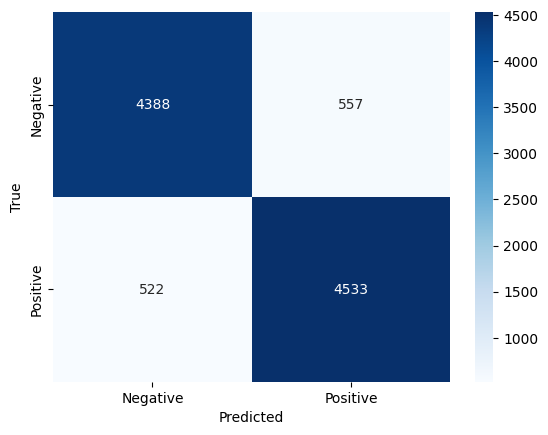

In [19]:
# EVALUATE THE MODEL
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predictions
y_pred = (model.predict(X_test) > 0.5).astype("int32")

# Report
print(classification_report(y_test, y_pred))

# Confusion Matrix Heatmap
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Negative", "Positive"],
            yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [20]:
# PREDICTIONS
while True:
    user_input = input("Enter a movie review (or type 'exit' to quit):\n")

    if user_input.lower() == 'exit':
        print("Exiting... Goodbye 👋")
        break

    # Clean and preprocess input
    cleaned_input = clean_text(user_input)
    input_seq = tokenizer.texts_to_sequences([cleaned_input])
    input_pad = pad_sequences(input_seq, maxlen=max_len)

    # Predict sentiment
    prediction = model.predict(input_pad)[0][0]
    sentiment = "Positive" if prediction > 0.5 else "Negative"

    print(f"\nPredicted Sentiment: {sentiment}")
    print(f"Confidence: {prediction:.2f}\n")


Enter a movie review (or type 'exit' to quit):
This movie was amazing, I loved it!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step

Predicted Sentiment: Positive
Confidence: 0.94

Enter a movie review (or type 'exit' to quit):
quit
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step

Predicted Sentiment: Negative
Confidence: 0.31

Enter a movie review (or type 'exit' to quit):
exit
Exiting... Goodbye 👋


In [21]:
import gradio as gr

def predict_sentiment(review):
    cleaned_input = clean_text(review)
    input_seq = tokenizer.texts_to_sequences([cleaned_input])
    input_pad = pad_sequences(input_seq, maxlen=max_len)
    prediction = model.predict(input_pad)[0][0]
    sentiment = "Positive" if prediction > 0.5 else "Negative"
    return f"{sentiment} (Confidence: {prediction:.2f})"

iface = gr.Interface(
    fn=predict_sentiment,
    inputs="text",
    outputs="text",
    title="Movie Review Sentiment Classifier",
    description="Enter a movie review and get the predicted sentiment!"
)

iface.launch()


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://6cf04e430ce9e7d5f0.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [22]:
# save and reload the model
# Save model & tokenizer
model.save("lstm_sentiment.h5")

import pickle
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

# Later: load them back
from tensorflow.keras.models import load_model
model = load_model("lstm_sentiment.h5")

with open("tokenizer.pkl", "rb") as f:
    tokenizer = pickle.load(f)
